# TODOs
- Investigate better difference measures.
- Parallelize the distance computation (to allow for efficient computation of the dendogramms)
- Implement matching
- Derive some trend metrics (e.g., change of attachment/adjacent nodes, relative growth, absolute growth-we need market capitalization for this.) for every cluster.
- Determine strongly growing clusters
- Generate test sets. I.e., invest on strongly growing clusters and check how performance would have been.

# Import Libraries

In [4]:

import pandas   # data manipulation
import os       # file system operations    
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt # plotting
import random  # random number generation

# Download Dataset

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

# path to stocks only:
path = path + "/Stocks/"

print(f"There are {len(os.listdir(path))} stocks in the dataset")

Path to dataset files: /Users/z003zckm/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3
There are 7195 stocks in the dataset


# Preprocess Data

In [6]:
# load all symbols in ./../data/sample1
symbols = []
for file in os.listdir(path):
    # check if file is a csv by content
    try:
        df = pandas.read_csv(path + f"/{file}")
        symbols.append(df)
    except:
        print(f"Skipping {file}")

Skipping pbio.us.txt
Skipping accp.us.txt
Skipping amrh.us.txt
Skipping vist.us.txt
Skipping srva.us.txt
Skipping bbrx.us.txt
Skipping bolt.us.txt
Skipping amrhw.us.txt
Skipping znwaa.us.txt
Skipping stnl.us.txt
Skipping hayu.us.txt
Skipping otg.us.txt
Skipping molc.us.txt
Skipping boxl.us.txt
Skipping sbt.us.txt
Skipping fmax.us.txt
Skipping rbio.us.txt
Skipping wnfm.us.txt
Skipping jt.us.txt
Skipping pxus.us.txt
Skipping vmet.us.txt
Skipping asns.us.txt
Skipping sfix.us.txt
Skipping scci.us.txt
Skipping sail.us.txt
Skipping wspt.us.txt
Skipping scph.us.txt
Skipping gnst.us.txt
Skipping send.us.txt
Skipping bxg.us.txt
Skipping mapi.us.txt
Skipping ehr.us.txt


Definition of the target signal

In [7]:

# Data schema
# Date	Open	High	Low	Close	Volume	OpenInt
# 0	1970-01-02	2.2972	2.3178	2.2972	2.2972	26437	0
# 1	1970-01-05	2.2972	2.2972	2.2544	2.2759	29887	0
# 2	1970-01-06	2.2759	2.2759	2.2342	2.2342	106900	0
# 3	1970-01-07	2.2342	2.2342	2.2342	2.2342	85061	0
# 4	1970-01-08	2.2342	2.2342	2.2139	2.2139	66669	0

# for all symbols compute the average price (high + low) / 2 and add as column
# for df in symbols:
#     df['AvgPrice'] = (df['High'] + df['Low']) / 2
    
# define the target signal
target_signal_name = 'target_signal'
for df in symbols:
    df[target_signal_name] = (df['Close'] - df['Open']) / df['Open']
    
# compute a common "time index" by finding first and last date and then map all dates to a number
first_date = min([min(df['Date']) for df in symbols])
last_date = max([max(df['Date']) for df in symbols])

# create a dictionary that maps dates to numbers
date_to_num = {}
num_to_date = {}
for idx, date in enumerate(pandas.date_range(first_date, last_date)):
    date_to_num[date] = idx
    num_to_date[idx] = date
    
# drop all columns but the  Date and AvgPrice columns
all_columns = df.columns
columns_to_keep = ['Date', target_signal_name]
columns_to_drop = [col for col in all_columns if col not in columns_to_keep]


# add the index to the dataframes
for idx, df in enumerate(tqdm(symbols)):
    # drop all columns but the  Date and AvgPrice columns
    df.drop(columns=columns_to_drop, inplace=True)
    
    # add the index
    df.loc[:, 'timeindex'] = df['Date'].map(date_to_num)    


100%|██████████| 7163/7163 [01:39<00:00, 71.64it/s]


In [8]:
symbols[0].tail()

,Date,target_signal,timeindex
3194,2017-11-06,0.002542,20397
3195,2017-11-07,-0.009612,20398
3196,2017-11-08,-0.007434,20399
3197,2017-11-09,0.004788,20400
3198,2017-11-10,-0.011181,20401


Create time slices: For example, we could work on slices of 1 year. Other slices are conceivable. It's important to only work with the symbols that are fully available in the slice.

In [9]:
# compute the slices
# from the last available time slot go back 350 days. The last remaning slot does not need to have 350 days. Then create a list with the index of the slice and the start and end index of the slice.
slices = []
max_index = max(num_to_date.keys())
# partition the data into slices of 350 days
for end in range(max_index, 0, -350):
    start = end - 350
    if start < 0:
        start = 0
    slices.append((start, end))


In [10]:
from tqdm import tqdm

# For every slice compute the available symbols (checking if the min and max timeindex is within the slice)

slice_availability = []
for idx, (start, end) in tqdm(enumerate(slices), total=len(slices), desc="Slices"):
    available_symbols = []
    for idx, df in tqdm(enumerate(symbols), total=len(symbols), desc=f"Symbols in slice {idx}", leave=False):
        if min(df['timeindex']) <= start and max(df['timeindex']) >= end:
            available_symbols.append(idx)
    slice_availability.append(available_symbols)


Slices: 100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


In [11]:
# Slice with the most symbols
max_symbols = max([len(s) for s in slice_availability])
# index of the slice with the most symbols
max_symbols_slice = [idx for idx, s in enumerate(slice_availability) if len(s) == max_symbols][0]
print(f"Slice with most symbols is {max_symbols_slice} with {max_symbols} symbols")

Slice with most symbols is 0 with 6084 symbols


In [12]:
random.seed(42)
symbols_selected_idx = random.sample(slice_availability[max_symbols_slice], 10)
print(f"Slice Window: start: {num_to_date[slices[max_symbols_slice][0]]}, end: {num_to_date[slices[max_symbols_slice][1]]}")
for idx in symbols_selected_idx:
    print(f"Symbol {idx}: start: {num_to_date[min(symbols[idx]['timeindex'])]}, end: {num_to_date[max(symbols[idx]['timeindex'])]}")

Slice Window: start: 2016-11-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 6165: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 1070: start: 1977-01-03 00:00:00, end: 2017-11-10 00:00:00
Symbol 244: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 7153: start: 2010-02-23 00:00:00, end: 2017-11-10 00:00:00
Symbol 2640: start: 2014-12-10 00:00:00, end: 2017-11-10 00:00:00
Symbol 2349: start: 1980-01-02 00:00:00, end: 2017-11-10 00:00:00
Symbol 2142: start: 2016-10-28 00:00:00, end: 2017-11-10 00:00:00
Symbol 1337: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 7109: start: 2005-02-25 00:00:00, end: 2017-11-10 00:00:00
Symbol 981: start: 2014-12-19 00:00:00, end: 2017-11-10 00:00:00


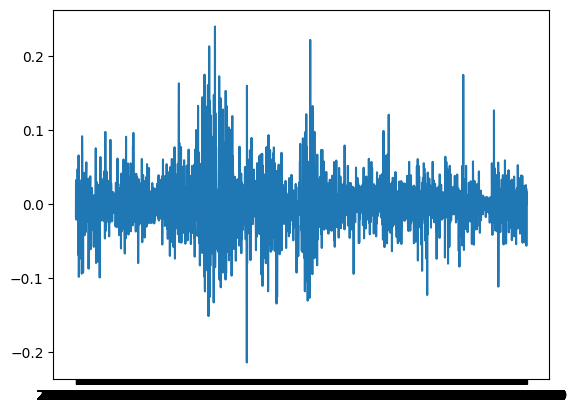

In [13]:
# plot symbol 6165
symbol = symbols[6165]
plt.plot(symbol['Date'], symbol[target_signal_name], label=f'Symbol_{idx}')
plt.show()

# Visualize Dataset (and some descriptive statistics)

<Figure size 640x480 with 0 Axes>

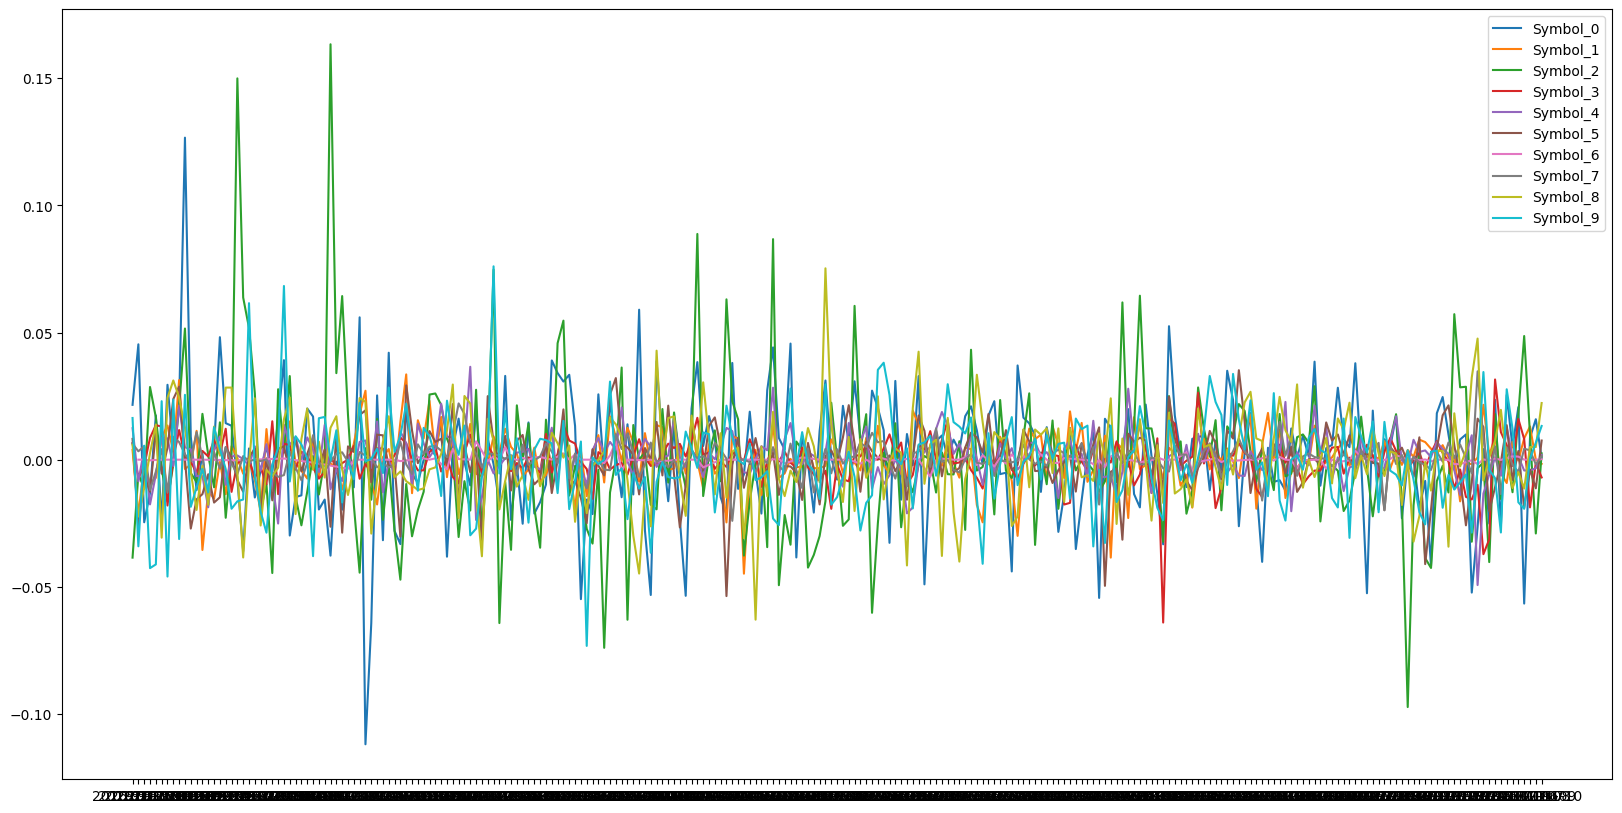

In [38]:
# choose slice
slice_idx = max_symbols_slice

# clear old plot
plt.clf()

# plot all symbols in a single chart
plt.figure(figsize=(20, 10))

# randomly select 10 symbols
random.seed(42)
selected_symbols_idx = random.sample(slice_availability[slice_idx], 10)

for idx, symbol_to_plot in enumerate(selected_symbols_idx):
    symbol = symbols[symbol_to_plot]
    # slice to the selected slice
    symbol = symbol[(symbol['timeindex'] >= slices[slice_idx][0]) & (symbol['timeindex'] <= slices[slice_idx][1])]
    # use the Date as x-axis and the AvgPrice as y-axis
    plt.plot(symbol['Date'], symbol[target_signal_name], label=f'Symbol_{idx}')
plt.legend()
plt.show()

# Detect clusters

Compute a dendrogram of the symbols

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram

def compute_dendrogram(selected_symbols, timerange):
    # Compute the distance matrix using FastDTW
    n = len(selected_symbols)
    distance_matrix = np.zeros((n, n))
    symbols_in_timerange = [symbol[symbol['timeindex'].between(timerange[0], timerange[1])] for symbol in selected_symbols]

    for i in tqdm(range(n), total=n, desc="Computing distance matrix"):
        for j in range(n):
            if i != j:
                distance, _ = fastdtw(symbols_in_timerange[i][target_signal_name], symbols_in_timerange[j][target_signal_name])
                distance_matrix[i, j] = distance
            else:
                distance_matrix[i, j] = 0  # Distance to self is zero

    # Perform hierarchical clustering using the distance matrix
    Z = linkage(distance_matrix, method='ward')  # You can choose other methods like 'average', 'single', etc.

    return Z



Computing distance matrix: 100%|██████████| 10/10 [00:00<00:00, 16.51it/s]
/var/folders/tz/x9zmsny551557y_7gwtsbhgw0000gn/T/ipykernel_37567/569753761.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # You can choose other methods like 'average', 'single', etc.


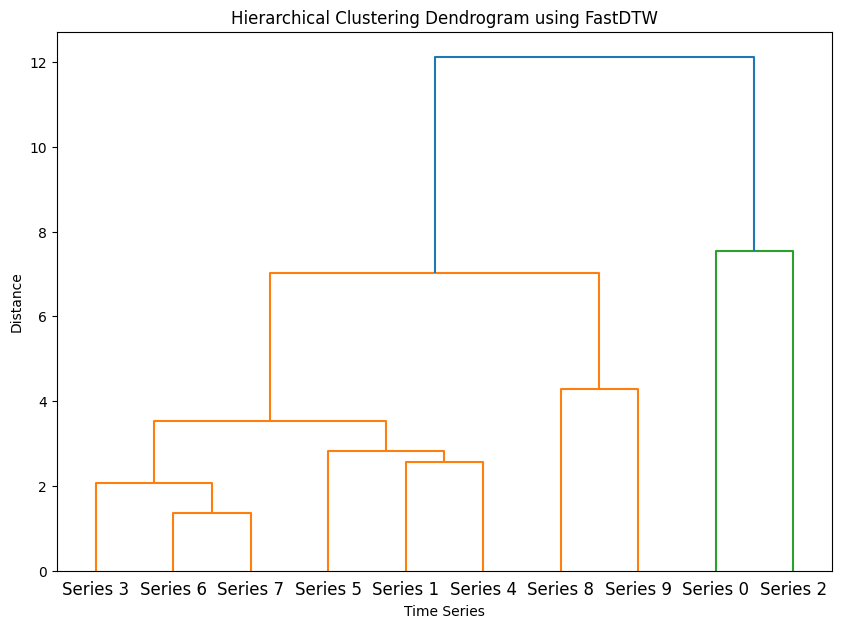

In [22]:
def plot_dendrogram(linkage_matrix):
    n = len(linkage_matrix) + 1
    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, labels=[f'Series {i}' for i in range(n)])
    plt.title('Hierarchical Clustering Dendrogram using FastDTW')
    plt.xlabel('Time Series')
    plt.ylabel('Distance')
    plt.show()


Computing distance matrix: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]
/var/folders/tz/x9zmsny551557y_7gwtsbhgw0000gn/T/ipykernel_37567/569753761.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # You can choose other methods like 'average', 'single', etc.
Computing distance matrix: 100%|██████████| 10/10 [00:00<00:00, 18.50it/s]


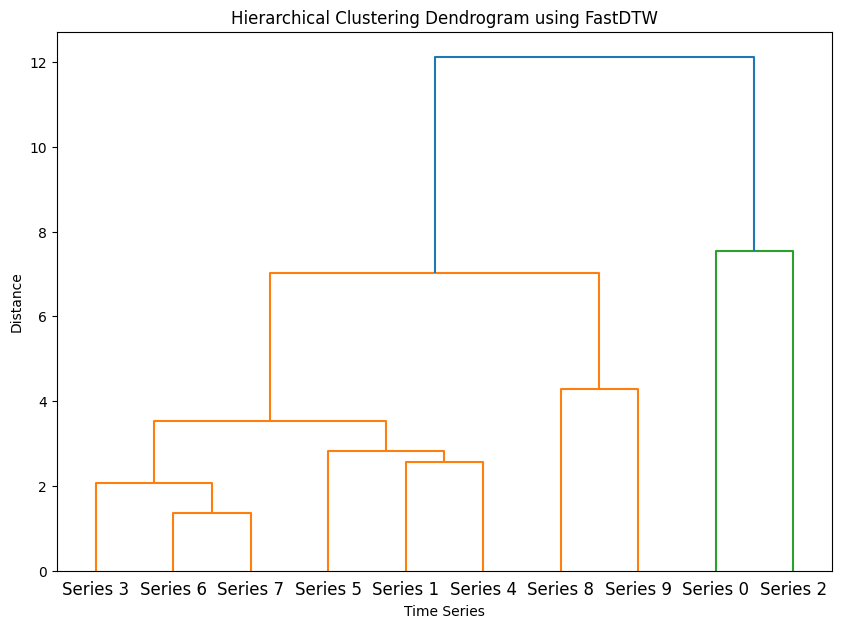

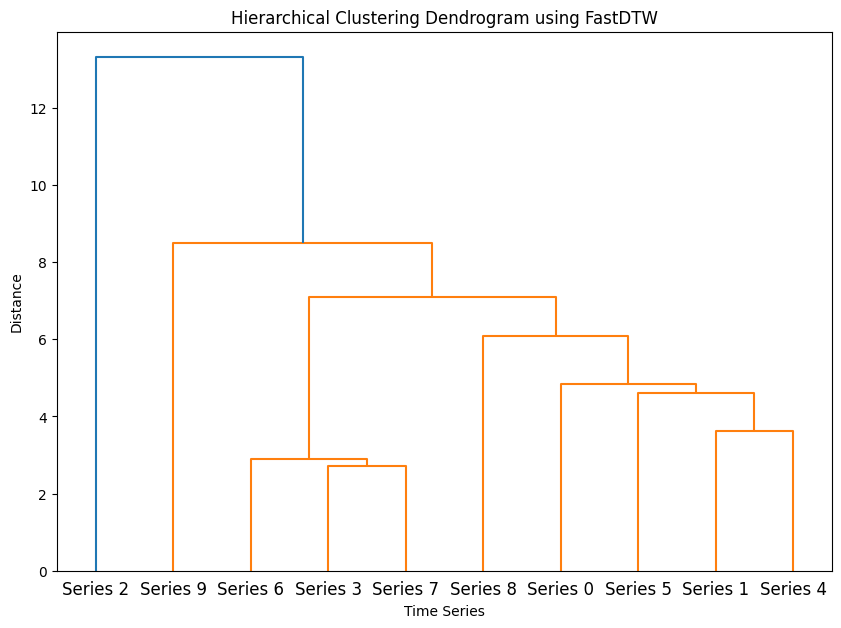

In [28]:
#selected_slice = max_symbols_slice
#selected_symbols_idx = slice_availability[selected_slice]
selected_symbols = [symbols[idx] for idx in selected_symbols_idx]

# get start and end timeindex for slice_idx
timerange = slices[slice_idx]
timerange_previous = slices[slice_idx + 1]
Z_new = compute_dendrogram(selected_symbols, timerange)
Z_old = compute_dendrogram(selected_symbols, timerange_previous)

plot_dendrogram(Z_new)
plot_dendrogram(Z_old)

# Matching
In this section we compute the matching of two graphs.

In [40]:
def symbols_from_linkage(symbols, Z):
    """Get the set of symbols for each tree node.
    
    Note: this works only for binary trees and needs to be adjusted for arbitary graphs.
    """
    node_to_symbols = [[symbol] for symbol in symbols]
    for link in Z:
        node_to_symbols.append(node_to_symbols[int(link[0])] + node_to_symbols[int(link[1])])
        
    return node_to_symbols

In [41]:
symbols_from_linkage(selected_symbols_idx, Z_new)

[[6165],
 [1070],
 [244],
 [7153],
 [2640],
 [2349],
 [2142],
 [1337],
 [7109],
 [981],
 [2142, 1337],
 [7153, 2142, 1337],
 [1070, 2640],
 [2349, 1070, 2640],
 [7153, 2142, 1337, 2349, 1070, 2640],
 [7109, 981],
 [7153, 2142, 1337, 2349, 1070, 2640, 7109, 981],
 [6165, 244],
 [7153, 2142, 1337, 2349, 1070, 2640, 7109, 981, 6165, 244]]

In [66]:
# TODO typically the different trees have different number of symbols, we only have to do this for the overlap of initial symbols here
# TODO we also should handle conflicts somehow, that is if two right hand clusters match on the same left hand cluster
def cluster_similarity(set_left, set_right):
    """Jaccard similarity"""
    overlap = float(len(set(set_left).intersection(set(set_right))))/float(len(set(set_right).union(set(set_left)))) # relative overlap
    return overlap

def compute_matching(symbol_cluster_left, symbol_cluster_right):
    """Compute a matching of sets.
    
    We match every set on the right with a set with the biggest relative overlap in symbol count.

    Args:
        symbol_cluster_left (list[list]): Clusters left hand side.
        symbol_cluster_right (list[list]): Clusters right hand side.
    """
    matching = {}
    similarities = {}
    for idx_right, cluster_right in enumerate(symbol_cluster_right):
        best_match = None
        best_sim = 0
        for idx_left, cluster_left in enumerate(symbol_cluster_left):
            sim = cluster_similarity(cluster_left, cluster_right)
            #print(f"Cluster left: {cluster_left}; Cluster right: {cluster_right}: sim: {sim}")
            if sim > best_sim:
                best_sim = sim
                best_match = idx_left
        matching[idx_right] = best_match
        similarities[idx_right] = best_sim
    return matching, similarities

In [67]:
cluster_left = symbols_from_linkage(selected_symbols_idx, Z_old)
cluster_right = symbols_from_linkage(selected_symbols_idx, Z_new)
print(cluster_left)
print(cluster_right)

[[6165], [1070], [244], [7153], [2640], [2349], [2142], [1337], [7109], [981], [7153, 1337], [2142, 7153, 1337], [1070, 2640], [2349, 1070, 2640], [6165, 2349, 1070, 2640], [7109, 6165, 2349, 1070, 2640], [2142, 7153, 1337, 7109, 6165, 2349, 1070, 2640], [981, 2142, 7153, 1337, 7109, 6165, 2349, 1070, 2640], [244, 981, 2142, 7153, 1337, 7109, 6165, 2349, 1070, 2640]]
[[6165], [1070], [244], [7153], [2640], [2349], [2142], [1337], [7109], [981], [2142, 1337], [7153, 2142, 1337], [1070, 2640], [2349, 1070, 2640], [7153, 2142, 1337, 2349, 1070, 2640], [7109, 981], [7153, 2142, 1337, 2349, 1070, 2640, 7109, 981], [6165, 244], [7153, 2142, 1337, 2349, 1070, 2640, 7109, 981, 6165, 244]]


In [68]:
cluster_left = symbols_from_linkage(selected_symbols_idx, Z_old)
cluster_right = symbols_from_linkage(selected_symbols_idx, Z_new)
compute_matching(cluster_left, cluster_right)

({0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 11,
  11: 11,
  12: 12,
  13: 13,
  14: 16,
  15: 8,
  16: 17,
  17: 0,
  18: 18},
 {0: 1.0,
  1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 0.6666666666666666,
  11: 1.0,
  12: 1.0,
  13: 1.0,
  14: 0.75,
  15: 0.5,
  16: 0.8888888888888888,
  17: 0.5,
  18: 1.0})